In [1]:
# iMPORT PACKAGES
import pandas as pd
import datetime as dt
import numpy as np
import math
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [22]:
data = pd.read_csv("out_without_nan_mood_normalised_extra_temp_train.csv")
data['date'] = pd.to_datetime(data['date'])
df = data.dropna(subset = ['mood_mean','mood_mean_TARGET'] )

In [23]:
# Create test and train set
def createTrainTest(length_train):
    length_train = length_train
    index_test = np.random.choice(np.arange(len(df)), length_train, False)

    test = df.iloc[index_test]
    train = df.drop(df.index[index_test])
    
    return train, test

In [24]:
# Calculate MSQ
def calculateAccMSQ(solutions, name_target,name_predicted):
    squared_error = 0
    for index, row in solutions.iterrows():
        squared_error += math.pow(row[name_target]-row[name_predicted],2)
    msq = squared_error / len(solutions.index)
    return msq

In [25]:
# Predict row
def predictMoodPersonARIMA(row, order):    
    #get train data
    train_data_person = df.loc[(df['id'] == row.id) & (df['date'] < row.date)]
    train_data_person_correct = train_data_person[['mood_mean_TARGET']]
    
    prediction_mood_target = None
    #fit the model
    if len(train_data_person_correct) > 10:
        model = ARIMA(train_data_person_correct, order=order)
        model_fit = model.fit()
    
        # make prediction on validation
        prediction = model_fit.forecast()
        prediction_mood_target = prediction[0][0]
    
    return prediction_mood_target 

In [26]:
# Find for every row in test set the predicted mood
def predictARIMA(test, order):
    solutions = pd.DataFrame(data={'id': [], 'date': [], 'mood_mean_target': [], 'predicted_mood_mean_target':[]})
    for index, row in test.iterrows():
        prediction_mood_target = predictMoodPersonARIMA(row, order)
    
        #add solution to solution df
        if prediction_mood_target is not None:
            solutions = solutions.append({'id': row.id, 'date': row.date, 'mood_mean_target': row.mood_mean_TARGET,
                                      'predicted_mood_mean_target': prediction_mood_target}, ignore_index=True)
    return solutions

In [32]:
test = df

In [28]:
#test = pd.read_csv("test_set.csv")
#train = pd.read_csv("train_set.csv")

In [29]:
#train, test = createTrainTest(100)

In [33]:
solutions = predictARIMA(test, (1,0,0))
msq = metrics.mean_squared_error(solutions['predicted_mood_mean_target'],solutions['mood_mean_target'])
r2 = metrics.r2_score(solutions['predicted_mood_mean_target'],solutions['mood_mean_target'])
print(msq)

0.44537526243176206


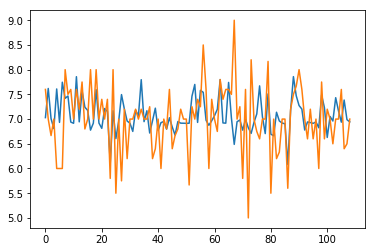

In [40]:
import matplotlib.pyplot as plt
plt.plot(solutions['predicted_mood_mean_target'])
plt.plot(solutions['mood_mean_target'])
plt.xlabel('Smarts')
plt.ylabel('Mood mean')
plt.title('Histogram of IQ')

plt.show()

In [11]:
(1,0,0) = 0.23438219609414976
(0,1,0) = 0.43916991521125376
(0,2,0) = 1.591560337768915
(1,2,0) = 0.8812095702372237
(2,2,0) = 0.7547504645377935
(3,2,0) = error
(3,1,0) = 0.32514441411836276
(4,1,0) = error
(1,1,0) = 0.4145036325619722
(3,0,0) = 0.3425771089769928
(4,0,0) = 0.351796666069525
(0,0,1) = 0.3009717375417968
(0,0,2) = 0.3740895788190101
(0,0,3) = error
(1,0,1) = error
(0,1,1) = 0.24253054075758185
(1,1,1) = error
(0,2,1) = 0.5064616756505296

SyntaxError: can't assign to literal (<ipython-input-11-f4155a6eed94>, line 1)

In [21]:
for p in range(4):
    for d in range(4):
        for q in range(4):
            try:
                solutions = predictARIMA(test, (p,d,q))
                msq = metrics.mean_squared_error(solutions['predicted_mood_mean_target'],solutions['mood_mean_target'])
                r2 = metrics.r2_score(solutions['predicted_mood_mean_target'],solutions['mood_mean_target'])
                x1= p,d,q
                print (x1,msq, r2)
            except:
                pass

(0, 0, 0) 0.42021160984967837 -1.4248869428975373
(0, 0, 1) 0.4334249118584043 -1.2875810085529573
(0, 1, 0) 0.6221848610389679 -0.12389023721338854
(0, 1, 1) 0.4745035417380524 -0.2631007908928462
(0, 2, 0) 1.828269432368806 -0.021610405682505274
(0, 2, 1) 0.7171563286926496 -0.05585332130717169
(1, 0, 0) 0.4088604977738055 -1.1975771631850138
(1, 1, 0) 0.5400079855710743 -0.1779037917853168
(1, 2, 0) 1.111698175639893 -0.019954233677418776
(2, 1, 0) 0.5717440981672484 -0.25702103675883436


In [49]:
test = pd.read_csv("out_without_nan_mood_normalised_extra_temp_test.csv")
data = pd.read_csv("out_without_nan_mood_normalised_extra_temp.csv")
data['date'] = pd.to_datetime(data['date'])
df = data.dropna(subset = ['mood_mean','mood_mean_TARGET'] )

In [50]:
solutions = predictARIMA(test, (2,1,0))
msq = metrics.mean_squared_error(solutions['predicted_mood_mean_target'],solutions['mood_mean_target'])
r2 = metrics.r2_score(solutions['predicted_mood_mean_target'],solutions['mood_mean_target'])
print(msq, r2)

0.4409907107432259 -0.06320701590518141


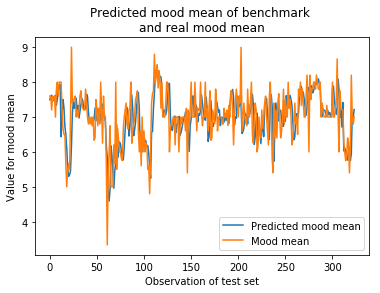

In [53]:
import matplotlib.pyplot as plt
plt.plot(solutions['predicted_mood_mean_target'])
plt.plot(solutions['mood_mean_target'])
plt.legend(["Predicted mood mean", "Mood mean"])
plt.xlabel('Observation of test set')
plt.ylabel('Value for mood mean')
plt.title('Predicted mood mean of ARIMA \nand real mood mean')
plt.savefig("arima1")

In [ ]:
plt.plot(solutions['predicted_mood_mean_target'] - solutions['mood_mean_target'])
plt.xlabel('Observation of test set')
plt.ylabel('Difference')
plt.title('Difference between predicted mood mean \n of benchmark and real mood mean')

plt.savefig("arima2")